In [1]:
import numpy as np
import pandas as pd
import re
import bisect
import os

import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import seaborn as sns
sns.set()

from IPython.display import Image

from sklearn.linear_model import LogisticRegression

from rpy2.robjects.packages import importr

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects import default_converter
from rpy2.robjects.conversion import localconverter
from rpy2.robjects.packages import importr


In [2]:
data_dir = '/Users/ychen/Documents/results/research/'
inline = 'test'
mydate = '20201006'


In [133]:
# import functions
from lib.amt_zeros_filter import amt_zeros_filter
from lib.amt_zeros_pct_filter import amt_zeros_pct_filter
from lib.whole_number_pct_filter import whole_number_pct_filter
from lib.exec_137_filter import exec_137_filter
from lib.exec_137_pct_filter import exec_137_pct_filter

from lib.is_name_factor import is_name_factor

from lib.compute_iv_numeric import compute_iv_numeric
from lib.iv_numeric_select import iv_numeric_select
from lib.compute_iv_cat import compute_iv_cat
from lib.iv_cat_select import iv_cat_select

from lib.log_transform import log_transform
from lib.recode import recode
from lib.create_dummy import create_dummy
from lib.recode_category_2_dummies import recode_category_2_dummies

from lib.compute_gains_bad_as_1 import compute_gains_bad_as_1
from lib.quick_eval import quick_eval
from lib.bad_money_saved_by_coverage import bad_money_saved_by_coverage
from lib.woe_plot import woe_plot
from lib.iv_merge import iv_merge



In [30]:
# Load data
trn_next = pd.read_csv(data_dir + 'trn_next_lr_20200930.csv')
val = pd.read_csv(data_dir + 'val_lr_20200930.csv')
print(trn_next.shape)
#print(trn_next.nunique())
print(val.shape)

trn = pd.read_csv(data_dir + 'trn_lr_20200930.csv')
print(trn.shape)


(483895, 39)
(466615, 94)
(483895, 99)


In [39]:
# Remove dummy with 'OTHER_', since it's already covered by other categories.
cols = trn_next.columns
bool_list = ['OTHER_' in i for i in cols]
filt_cols = [cols[i] for i, val in enumerate(bool_list) if val==False]
trn_final = trn_next[filt_cols]
print(trn_final.shape)
print(trn_final.nunique())


(483895, 37)
flag                                                       2
send_amount_one_continuous                                10
amt_zeros_pct                                             12
sender_age_at_xfer_creation_year_continuous               84
send_amount_hundred_continuous                            10
send_amount_ten_continuous                                10
filter_137_pct                                            12
whole_number_pct                                           5
amt_zeros                                                  6
ln_receive_amount_continuous                           68819
ln_send_amount_continuous                               7251
ln_account_age_at_xfer_creation_day_continuous          2281
receive_currency_factor__PHP                               2
receive_currency_factor__USD                               2
receive_currency_factor__MXN                               2
expedited_factor__1                                        2
recipient_a

In [40]:
# rpy2
# Allow conversion
pandas2ri.activate()

# Convert to R dataframe
r_trn_final = ro.conversion.py2rpy(trn_final) # trn_next is a pd.DataFrame object

## Convert back to pandas DataFrame        
#pd_dt = ro.conversion.rpy2py(r_dt)


In [5]:
# Import packages
base, stats = importr('base'), importr('stats')

# Import Functions
glm = stats.glm
#hpc, rsmax2, tabu = bnlearn.hpc, bnlearn.rsmax2, bnlearn.tabu


/Users/ychen/Documents/projects/research/env3/lib/python3.8/site-packages/rpy2/robjects/vectors.py:969: UserWarning: R object inheriting from "POSIXct" but without attribute "tzone".
  warnings.warn('R object inheriting from "POSIXct" but without '


In [44]:
rstring="""
    function(raw){
        # Forward stepwise regression
        null.raw <- glm(flag~1, family=binomial, data=raw)
        print(summary(null.raw))
        
        full.raw <- glm(flag~., family=binomial, data=raw)
        print(summary(full.raw))
        
        # At most 20 vars selected
        step.raw <- step(null.raw, scope=list(lower=null.raw, upper=full.raw), direction="forward", steps=20)
        desp <- summary(step.raw)
        print(desp)
        
        coeff <- as.data.frame(desp$coefficients)
        names(coeff) <- c("Estimate", "StdError", "z_value", "pr_gt_abs_z")
        coeff
    }
"""
rfunc = ro.r(rstring)
r_coeff = rfunc(r_trn_final)

# Convert back to pandas DataFrame
coeff_df = ro.conversion.rpy2py(r_coeff)
print(coeff_df)




Call:
glm(formula = flag ~ 1, family = binomial, data = raw)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.1236  -0.1236  -0.1236  -0.1236   3.1234  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -4.87023    0.01654  -294.5   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 43280  on 483894  degrees of freedom
Residual deviance: 43280  on 483894  degrees of freedom
AIC: 43282

Number of Fisher Scoring iterations: 7


Call:
glm(formula = flag ~ ., family = binomial, data = raw)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.0988  -0.0969  -0.0626  -0.0438   4.2313  

Coefficients: (2 not defined because of singularities)
                                                     Estimate Std. Error
(Intercept)                                         -3.273057   0.316179
send_amount_one_continuous         

+ payment_type_factor__2                               1    43140 43144
+ send_amount_ten_continuous                           1    43182 43186
+ browser_string_length_in_characters_is_90_factor__Y  1    43185 43189
+ receive_currency_factor__USD                         1    43194 43198
+ device_id_exists_factor__Y                           1    43194 43198
+ recipient_country_is_pe_factor__Y                    1    43197 43201
+ browser_string_exists_factor__Y                      1    43198 43202
+ receive_currency_factor__MXN                         1    43206 43210
+ recipient_country_is_mx_factor__Y                    1    43206 43210
+ network_id_is_5180_factor__Y                         1    43213 43217
+ sender_age_at_xfer_creation_year_continuous          1    43214 43218
+ geo_code_is_87_factor__Y                             1    43218 43222
+ receive_method_factor__2                             1    43218 43222
+ ln_receive_amount_continuous                         1    4326

+ send_amount_one_continuous                           1    35190 35200
+ sender_age_at_xfer_creation_year_continuous          1    35221 35231
+ send_amount_ten_continuous                           1    35248 35258
+ device_id_exists_factor__Y                           1    35299 35309
+ browser_string_length_in_characters_is_90_factor__Y  1    35314 35324
+ browser_string_exists_factor__Y                      1    35320 35330
+ is_first_xfer_factor__1                              1    35331 35341
+ receive_method_factor__2                             1    35349 35359
+ receive_currency_factor__USD                         1    35353 35363
+ geo_code_is_87_factor__Y                             1    35365 35375
+ network_id_is_5180_factor__Y                         1    35367 35377
+ ln_send_amount_continuous                            1    35377 35387
+ recipient_country_is_pe_factor__Y                    1    35378 35388
+ ln_receive_amount_continuous                         1    3539

+ filter_137_pct                                       1    33292 33308
+ receive_currency_factor__MXN                         1    33293 33309
+ recipient_country_is_mx_factor__Y                    1    33293 33309
+ geo_code_is_33_factor__Y                             1    33295 33311
+ recipient_country_is_gt_factor__Y                    1    33295 33311
+ send_amount_ten_continuous                           1    33296 33312
+ amt_zeros_pct                                        1    33296 33312
<none>                                                      33299 33313
+ send_amount_hundred_continuous                       1    33297 33313
+ ln_send_amount_continuous                            1    33299 33315
+ recipient_country_is_pe_factor__Y                    1    33299 33315

Step:  AIC=33079.48
flag ~ ln_account_age_at_xfer_creation_day_continuous + expedited_factor__1 + 
    payment_type_factor__2 + network_id_is_5020_factor__Y + recipient_state_country_is_PH_MAN_factor__Y + 
 

flag ~ ln_account_age_at_xfer_creation_day_continuous + expedited_factor__1 + 
    payment_type_factor__2 + network_id_is_5020_factor__Y + recipient_state_country_is_PH_MAN_factor__Y + 
    amt_zeros + receive_method_factor__1 + browser_language_is_en_us_factor_1__Y + 
    sender_age_at_xfer_creation_year_continuous + is_first_xfer_factor__1

                                                      Df Deviance   AIC
+ recipient_address_exists_factor__Y                   1    32534 32558
+ geo_code_is_170_factor__Y                            1    32542 32566
+ geo_code_is_10_factor__Y                             1    32544 32568
+ browser_language_is_en_us_en_q_factor_1__Y           1    32554 32578
+ whole_number_pct                                     1    32559 32583
+ device_id_exists_factor__Y                           1    32563 32587
+ receive_currency_factor__MXN                         1    32572 32596
+ recipient_country_is_mx_factor__Y                    1    32572 32596
+ recei

+ browser_string_length_in_characters_is_90_factor__Y  1    32397 32427
+ receive_currency_factor__MXN                         1    32397 32427
+ recipient_country_is_mx_factor__Y                    1    32397 32427
+ network_id_is_5180_factor__Y                         1    32402 32432
+ geo_code_is_87_factor__Y                             1    32403 32433
+ ln_receive_amount_continuous                         1    32404 32434
+ filter_137_pct                                       1    32407 32437
+ send_amount_hundred_continuous                       1    32408 32438
+ ln_send_amount_continuous                            1    32408 32438
+ receive_method_factor__4                             1    32409 32439
+ receive_method_factor__2                             1    32409 32439
+ send_amount_ten_continuous                           1    32410 32440
<none>                                                      32412 32440
+ recipient_country_is_pe_factor__Y                    1    3241

    geo_code_is_170_factor__Y + geo_code_is_33_factor__Y + whole_number_pct + 
    receive_currency_factor__USD + device_id_exists_factor__Y

                                                      Df Deviance   AIC
+ browser_language_is_en_us_en_q_factor_1__Y           1    32071 32109
+ receive_currency_factor__PHP                         1    32099 32137
+ receive_currency_factor__MXN                         1    32101 32139
+ recipient_country_is_mx_factor__Y                    1    32101 32139
+ send_amount_ten_continuous                           1    32105 32143
+ send_amount_one_continuous                           1    32105 32143
+ amt_zeros_pct                                        1    32116 32154
+ browser_string_length_in_characters_is_90_factor__Y  1    32118 32156
+ filter_137_pct                                       1    32122 32160
+ network_id_is_5180_factor__Y                         1    32126 32164
+ geo_code_is_87_factor__Y                             1    32129 

is_first_xfer_factor__1                         0.501903   0.045507  11.029
recipient_address_exists_factor__Y             -0.224026   0.057538  -3.894
geo_code_is_10_factor__Y                        1.390447   0.100130  13.886
geo_code_is_170_factor__Y                       1.033316   0.072758  14.202
geo_code_is_33_factor__Y                        0.985691   0.081852  12.042
whole_number_pct                               -2.092853   0.324223  -6.455
receive_currency_factor__USD                   -0.714698   0.070436 -10.147
device_id_exists_factor__Y                     -0.623281   0.071198  -8.754
browser_language_is_en_us_en_q_factor_1__Y      0.375926   0.045197   8.318
receive_currency_factor__PHP                   -0.660458   0.088023  -7.503
receive_currency_factor__MXN                   -0.455091   0.066944  -6.798
                                               Pr(>|z|)    
(Intercept)                                     < 2e-16 ***
ln_account_age_at_xfer_creation_day_continuo

In [60]:
# Remove insignificant coefficients
print(coeff_df.shape)
coefficient_df = coeff_df[coeff_df.pr_gt_abs_z <= 0.1]
print(coefficient_df.shape)


(21, 4)
(20, 4)


In [61]:
# Save the coefficients
coefficient_df.to_csv(data_dir + 'step20_coefficient_df_' + inline + '_' + mydate + '.csv', index=True)
print(coefficient_df.index)
print(len(coefficient_df.index))


Index(['(Intercept)', 'ln_account_age_at_xfer_creation_day_continuous',
       'expedited_factor__1', 'payment_type_factor__2',
       'recipient_state_country_is_PH_MAN_factor__Y', 'amt_zeros',
       'receive_method_factor__1', 'browser_language_is_en_us_factor_1__Y',
       'sender_age_at_xfer_creation_year_continuous',
       'is_first_xfer_factor__1', 'recipient_address_exists_factor__Y',
       'geo_code_is_10_factor__Y', 'geo_code_is_170_factor__Y',
       'geo_code_is_33_factor__Y', 'whole_number_pct',
       'receive_currency_factor__USD', 'device_id_exists_factor__Y',
       'browser_language_is_en_us_en_q_factor_1__Y',
       'receive_currency_factor__PHP', 'receive_currency_factor__MXN'],
      dtype='object')
20


In [62]:
# Validation data wrangling
val_vars_ln = ['ln_account_age_at_xfer_creation_day_continuous'] # 1
val_vars_dummy = ['expedited_factor__1', 'payment_type_factor__2', 'recipient_state_country_is_PH_MAN_factor__Y', 
    'receive_method_factor__1', 'browser_language_is_en_us_factor_1__Y', 'is_first_xfer_factor__1', 
    'recipient_address_exists_factor__Y', 'geo_code_is_10_factor__Y', 'geo_code_is_170_factor__Y', 
    'geo_code_is_33_factor__Y', 'receive_currency_factor__USD', 'device_id_exists_factor__Y', 
    'browser_language_is_en_us_en_q_factor_1__Y', 'receive_currency_factor__PHP', 'receive_currency_factor__MXN'] # 15
val_vars_derived = ['amt_zeros', 'whole_number_pct'] # 2
val_vars_orig = ['sender_age_at_xfer_creation_year_continuous'] # 1

# Log transform
val_log_df = log_transform(val[['account_age_at_xfer_creation_day_continuous']])
print(val_log_df.describe())

# Derived payment amount signals
pmt_df = val[['send_amount_continuous']]
pmt_df = pmt_df.assign(amt_zeros = [amt_zeros_filter(x) for x in pmt_df.send_amount_continuous])
pmt_df = pmt_df.assign(whole_number_pct = [whole_number_pct_filter(x) for x in pmt_df.send_amount_continuous])
val_derived_df = pmt_df[val_vars_derived]
print(val_derived_df.describe())


/Users/ychen/Documents/projects/research/env3/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


       ln_account_age_at_xfer_creation_day_continuous
count                                   466615.000000
mean                                         5.601037
std                                          1.702585
min                                          0.000000
25%                                          5.111988
50%                                          6.066108
75%                                          6.679599
max                                          7.757051
           amt_zeros  whole_number_pct
count  466615.000000     466615.000000
mean        3.111985          0.248858
std         0.945404          0.044560
min         0.000000          0.000000
25%         3.000000          0.250000
50%         3.000000          0.250000
75%         4.000000          0.250000
max         5.000000          0.333333


In [63]:
# Get dummies for validation
#print(trn.expedited_factor.value_counts())
#print(trn.expedited_factor.head())
#print(trn_final.expedited_factor__1.head())

def get_val_dummy_df(var_name, df, sep='__'):
    name_list = var_name.split(sep)
    orig = name_list[0]
    category = name_list[1]
    # Original signal must be str
    df[orig] = df[orig].astype(str)
    return pd.DataFrame({var_name: [1 if x==category else 0 for x in df[orig]]})

#print(val.expedited_factor.head())
#print(get_val_dummy_df('expedited_factor__1', val).head())

#print(val.payment_type_factor.head())
#print(get_val_dummy_df('payment_type_factor__2', val).head())

df_dummy = pd.DataFrame()
for var in val_vars_dummy:
    print(var)
    df_tmp = get_val_dummy_df(var, val)
    df_dummy = pd.concat([df_dummy, df_tmp], axis=1)
    
print(df_dummy.shape)
print(df_dummy.nunique())



expedited_factor__1
payment_type_factor__2
recipient_state_country_is_PH_MAN_factor__Y
receive_method_factor__1
browser_language_is_en_us_factor_1__Y
is_first_xfer_factor__1
recipient_address_exists_factor__Y
geo_code_is_10_factor__Y
geo_code_is_170_factor__Y
geo_code_is_33_factor__Y
receive_currency_factor__USD
device_id_exists_factor__Y
browser_language_is_en_us_en_q_factor_1__Y
receive_currency_factor__PHP
receive_currency_factor__MXN
(466615, 15)
expedited_factor__1                            2
payment_type_factor__2                         2
recipient_state_country_is_PH_MAN_factor__Y    2
receive_method_factor__1                       2
browser_language_is_en_us_factor_1__Y          2
is_first_xfer_factor__1                        2
recipient_address_exists_factor__Y             2
geo_code_is_10_factor__Y                       2
geo_code_is_170_factor__Y                      2
geo_code_is_33_factor__Y                       2
receive_currency_factor__USD                   2
device

'\n'

In [66]:
# Put it together for validation
val_final = pd.concat([val[['flag']], val_log_df, val_derived_df, df_dummy, val[val_vars_orig]], axis=1)
print(val_final.shape)
print(val_final.nunique())
                       

(466615, 20)
flag                                                 2
ln_account_age_at_xfer_creation_day_continuous    2337
amt_zeros                                            6
whole_number_pct                                     5
expedited_factor__1                                  2
payment_type_factor__2                               2
recipient_state_country_is_PH_MAN_factor__Y          2
receive_method_factor__1                             2
browser_language_is_en_us_factor_1__Y                2
is_first_xfer_factor__1                              2
recipient_address_exists_factor__Y                   2
geo_code_is_10_factor__Y                             2
geo_code_is_170_factor__Y                            2
geo_code_is_33_factor__Y                             2
receive_currency_factor__USD                         2
device_id_exists_factor__Y                           2
browser_language_is_en_us_en_q_factor_1__Y           2
receive_currency_factor__PHP                        

In [73]:
# Prediction on validation
# Convert to R dataframe
trn_vars = coefficient_df.index.tolist()
trn_vars[0] = 'flag'
trn_final_final = trn_final[trn_vars]
print(trn_final_final.shape)
#print(trn_final_final.nunique())
print(val_final.shape)
#print(val_final.nunique())

r_trn_final_final = ro.conversion.py2rpy(trn_final_final)
r_val_final = ro.conversion.py2rpy(val_final)

rstring="""
    function(trn, val){
        # Train on trn
        trn.glm <- glm(flag~., family=binomial, data=trn)
        
        # Predict on val
        y <- predict.glm(trn.glm, val[, -1])
        
        # y is ln_odds = pr(bads)/pr(goods)
        # The higher the y, the more bads
        # However, the score is the opposite, the lower the score, the more bads
        # Hence we need take a negative of y
        yhat = -y
        score = round(yhat*10000)/10000
        confu.val <- cbind(val[, 1], score)
        confu.val <- as.data.frame(confu.val)
        names(confu.val) <- c("target", "output")
        confu.val
    }
"""
rfunc = ro.r(rstring)
r_confu_val = rfunc(trn_final_final, val_final)

# Convert back to pandas DataFrame
confu_val_df = ro.conversion.rpy2py(r_confu_val)
print(confu_val_df)



(483895, 20)
(466615, 20)
        target  output
0          0.0  5.1612
1          0.0  6.2530
2          0.0  4.5045
3          0.0  4.4942
4          0.0  7.0810
...        ...     ...
466610     0.0  6.6308
466611     0.0  6.2101
466612     0.0  6.5332
466613     0.0  7.2359
466614     0.0  7.6724

[466615 rows x 2 columns]


'\n'

In [77]:
# Save the prediction results
confu_val_df.to_csv(data_dir + 'step20_confu_val_' + inline + '_' + mydate + '.csv', index=False)
print(confu_val_df.describe())


              target         output
count  466615.000000  466614.000000
mean        0.004871       6.043553
std         0.069624       1.240958
min         0.000000      -3.165600
25%         0.000000       5.359200
50%         0.000000       6.215600
75%         0.000000       6.920300
max         1.000000       8.911900


In [75]:
"""
# Scikit-learn
trn_vars = coefficient_df.index[1:].tolist()
trn_vars[0] = 'flag'
print(trn_vars)

# All parameters not specified are set to their defaults
logisticRegr = LogisticRegression()

x_train = trn_final[trn_vars]
y_train = trn_final.flag
logisticRegr.fit(x_train, y_train)

x_test = val_final[trn_vars]
y_test = val_final.flag
y = logisticRegr.predict(x_test)
"""


"\n# Scikit-learn\ntrn_vars = coefficient_df.index[1:].tolist()\ntrn_vars[0] = 'flag'\nprint(trn_vars)\n\n# All parameters not specified are set to their defaults\nlogisticRegr = LogisticRegression()\n\nx_train = trn_final[trn_vars]\ny_train = trn_final.flag\nlogisticRegr.fit(x_train, y_train)\n\nx_test = val_final[trn_vars]\ny_test = val_final.flag\ny = logisticRegr.predict(x_test)\n"

In [84]:
# Gains chart

def compute_gains_bad_as_1(target, output, rs_rate_0, rs_rate_1, n_bins):
    """
    Args:
        target: Array of target, 0 or 1 for binary classification.
        output: Array of numerical signal.
        rs_rate_0: Reverse sampling rate for negative.
        rs_rate_1: Reverse sampling rate for positive.
        n_bins: Number of bins.
    Returns:
        A data frame as gains charts.

    Usage example:
        eval = compute_iv_numeric(target, output, 1, 1, 100)
    """
    import pandas as pd
    import numpy as np
    import bisect

    #interval = 1.0/n_bins
    sbreaks = np.linspace(0, 1, (n_bins + 1), endpoint=True)
    o_quar = pd.Series(output).quantile(sbreaks)
    a = sorted(o_quar.drop_duplicates())
    b = [bisect.bisect_right(a, x, lo=0, hi=(len(a)-1)) for x in output]

    n = len(a)
    tot = np.repeat(0, n-1)
    bads = np.repeat(0, n-1)
    goods = np.repeat(0, n-1)
    tmp = [target[i] for i, val in enumerate(target) if val==0]
    ngoods = len(tmp)*rs_rate_0
    tmp = [target[i] for i, val in enumerate(target) if val==1]
    nbads = len(tmp)*rs_rate_1
    ntot = ngoods + nbads

    for i in np.arange(1, n):
        st = [target[ix] for ix, val in enumerate(b) if val==i]
        tmp = [st[i] for i, val in enumerate(st) if val==0]
        goods[i-1] = len(tmp)*rs_rate_0
        tmp = [st[i] for i, val in enumerate(st) if val==1]
        bads[i-1] = len(tmp)*rs_rate_1
        tot[i-1] = goods[i-1] + bads[i-1]

    cumtot = np.cumsum(tot, dtype=float)
    cumbads = np.cumsum(bads, dtype=float)
    cumgoods = np.cumsum(goods, dtype=float)
    pctpop = cumtot/ntot

    prgoods = goods/ngoods
    prbads = bads/nbads
    wpattern = np.log(prgoods/prbads)
    prcumgoods = np.cumsum(prgoods)
    prcumbads = np.cumsum(prbads)
    iv = (prgoods - prbads)*wpattern
    ks = np.max(np.abs(prcumbads - prcumgoods))

    hitrate = cumbads/cumtot
    coverage = cumbads/nbads
    intervalbads = bads/tot

    print(len(a))
    print(len(goods))
    print(len(bads))

    
    z = pd.DataFrame({'output': a[:-1],
                      'goods': np.round(goods),
                      'bads': np.round(bads),
                      'prtotal': np.round(pctpop, 6),
                      'prgoods': np.round(prgoods, 6),
                      'prbads': np.round(prbads, 6),
                      'wpattern': np.round(wpattern, 6),
                      'prcumgoods': np.round(prcumgoods, 6),
                      'prcumbads': np.round(prcumbads, 6),
                      'iv': np.round(iv, 6),
                      'hitrate': np.round(hitrate, 6),
                      'coverage': np.round(coverage, 6),
                      'intervalbads': np.round(intervalbads, 6)
        })
    return z, ks

eval_val_step20, ks_step20 = compute_gains_bad_as_1(confu_val_df.target, confu_val_df.output, 1, 1, 100)
print(eval_val_step20.shape)
print(eval_val_step20.describe())
print(eval_val_step20.head())
print(ks_step20)


101
100
100
(100, 13)
           output        goods        bads     prtotal     prgoods  \
count  100.000000   100.000000  100.000000  100.000000  100.000000   
mean     5.964907  4643.420000   22.730000    0.504988    0.010000   
std      1.496396    73.829065   73.454288    0.290114    0.000159   
min     -3.165600  3952.000000    2.000000    0.010002    0.008511   
25%      5.348200  4647.750000    6.000000    0.257481    0.010010   
50%      6.201100  4656.000000    9.000000    0.504985    0.010027   
75%      6.898325  4662.000000   14.250000    0.752479    0.010040   
max      8.222487  4678.000000  715.000000    1.000000    0.010074   

           prbads    wpattern  prcumgoods   prcumbads          iv     hitrate  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.010000    0.758664    0.503487    0.811707    0.020284    0.014604   
std      0.032316    0.919555    0.290848    0.147814    0.110360    0.019731   
min      0.000880   -3.

In [86]:
# Save the gains chart
eval_val_step20.to_csv(data_dir + 'step20_eval_val_step20_' + inline + '_' + mydate + '.csv', index=False)
print(eval_val_step20.head())


     output  goods  bads   prtotal   prgoods    prbads  wpattern  prcumgoods  \
0 -3.165600   3952   715  0.010002  0.008511  0.314562 -3.609826    0.008511   
1  2.447426   4516   150  0.020002  0.009726  0.065992 -1.914774    0.018237   
2  3.001352   4550   110  0.029988  0.009799  0.048394 -1.597119    0.028035   
3  3.317400   4576    94  0.039997  0.009855  0.041355 -1.434235    0.037890   
4  3.542300   4579    89  0.050001  0.009861  0.039155 -1.378921    0.047751   

   prcumbads        iv   hitrate  coverage  intervalbads  
0   0.314562  1.104792  0.153203  0.314562      0.153203  
1   0.380554  0.107738  0.092682  0.380554      0.032147  
2   0.428949  0.061641  0.069678  0.428949      0.023605  
3   0.470304  0.045179  0.057279  0.470304      0.020128  
4   0.509459  0.040394  0.049634  0.509459      0.019066  


In [149]:
# A quick evaluation

def quick_eval(df, cutoff, rs_rate_0, rs_rate_1):
    """
    Args:
        df: A data frame w/ 2 column: target and output.
        cutoff: A cutoff selected from Gains chart's score.
        rs.rate.0: reverse sampling rate for negative.
        rs.rate.1: reverse sampling rate for positive.
    Returns:
        A df of 4 columns:
        (1) auto queue in %
        (2) auto queue in count
        (3) hit rate in %
        (4) coverage in %
    Usage example:
        output_data = QuickEval(df, -0.5, 1, 1)
    """
    dim = df[df.target==1].shape
    nbads = dim[0]*rs_rate_1
    dim = df[df.target==0].shape
    ngoods = dim[0]*rs_rate_0
    ntot = nbads + ngoods

    x = df[df.output <= cutoff]
    dim = x[x.target==1].shape
    n_flag_bads = dim[0]*rs_rate_1
    dim = x[x.target==0].shape
    n_flag_goods = dim[0]*rs_rate_0
    n_flag_tot = n_flag_bads + n_flag_goods

    fra = 100.0*n_flag_tot/ntot
    hit = 100.0*n_flag_bads/n_flag_tot
    cov = 100.0*n_flag_bads/nbads

    z = pd.DataFrame({'queue_size': [fra],
                      'transactions': [n_flag_tot],
                      'hit_rate': [hit],
                      'coverage': [cov],
        })
    return z

qe_df = quick_eval(confu_val_df, 1.0, 1.0, 1.0)

# 0.18% queue, 863 transactions, 47% hit rate, 18% coverage
print(qe_df)

qe_df.to_csv(data_dir + 'step20_quick_eval_' + inline + '_' + mydate + '.csv', index=False)

# Approximated money saved by a model's coverage.
def bad_money_saved_by_coverage(pmt_var_name, coverage, df):
    """
    Args:
        pmt_var_name: signal name for money sent.
        coverage.
        df.
    Returns:
        A proxy of money saved by the model's coverage.
    """   
    bad_df = df[df.flag==1]
    return round(bad_df[pmt_var_name].astype(float).sum()*coverage/100.0, 2)

print(bad_money_saved_by_coverage('send_amount_continuous', qe_df.coverage[0], val))


   queue_size  transactions   hit_rate   coverage
0    0.184949         863.0  47.392816  17.993841
150622.97


In [96]:
# Interval bads vs. prob cum bads for the 1st 20 bins
rstring="""
    function(eval_df, n_bins, data_dir){
        PlotBarXY <- function(bar, xy, title.name, bar.name, xy.name, chart.name) {
            # PNG plot of barplot overlaps w/ XY plot
            #
            # Args:
            #   bar
            #   xy
            #   title.name
            #   bar.name
            #   xy.name
            #   chart.name
            #
            # Returns:
            #   A PNG plot of barplot overlays w/ XY plot
    
            png(file=chart.name, bg="transparent")
            intervalbads <- bar
            prcumbads <- xy

            tmp <- intervalbads[!is.na(intervalbads)]
            myrange <- range(c(0, tmp, prcumbads))
            ix <- 1:length(intervalbads)

            # Add extra space to right margin of plot within frame
            par(mar=c(5, 4, 4, 4) + 0.1)
            barplot(intervalbads, axes=F, ylim=myrange, xlab="bins", ylab="", col="blue", main=title.name)
            axis(2, ylim=myrange, col="blue")
            mtext(bar.name, side=2, col="blue", line=2.5)
            box()

            # Allow a second plot on the same graph
            par(new=T)
            plot(ix, prcumbads, pch=15, xlab="", ylab="", ylim=myrange, axes=F, type="l", col="red", lwd=2)
            axis(4, ylim=myrange, col="red", col.axis="red", lty=2, tck=1)
            axis(1, ylim=myrange, at=ix, lty=2, fg="grey")
            mtext(xy.name, side=4, col="red", line=2.5)

            # Add legend
            legend("top", c(bar.name, xy.name), lty = c(1, 1), col = c("blue", "red"), lwd=2)

            dev.off()
            return()
        }
        
        z <- eval_df[1:n_bins, ]
        bar.name <- "intervalbads"
        xy.name <- "prcumbads"
        title.name <- "interval bads vs. prob of cum bads"
        chart.name <- paste(data_dir, "/", "intervalbads_prcumbads", ".png", sep="")
        PlotBarXY(z$intervalbads, z$prcumbads, title.name, bar.name, xy.name, chart.name)
        z[, c("intervalbads", "prcumbads")]
    }
"""
r_eval_val_step20 = ro.conversion.py2rpy(eval_val_step20)
rfunc = ro.r(rstring)
r_intervalbads_prcumbads = rfunc(r_eval_val_step20, 20, data_dir)

# Convert back to pandas DataFrame
intervalbads_prcumbads_df = ro.conversion.rpy2py(r_intervalbads_prcumbads)
print(intervalbads_prcumbads_df)


    intervalbads  prcumbads
0       0.153203   0.314562
1       0.032147   0.380554
2       0.023605   0.428949
3       0.020128   0.470304
4       0.019066   0.509459
5       0.012645   0.535416
6       0.014194   0.564452
7       0.009186   0.583370
8       0.006427   0.596568
9       0.006225   0.609327
10      0.006635   0.622965
11      0.005576   0.634404
12      0.007071   0.648922
13      0.004291   0.657721
14      0.003211   0.664320
15      0.003428   0.671359
16      0.004930   0.681478
17      0.003431   0.688517
18      0.002786   0.694237
19      0.003856   0.702156


In [98]:
# Hitrate vs. coverage for the 1st 20 bins
rstring="""
    function(eval_df, n_bins, data_dir){
        Plot2XY <- function(y1, y2, title.name, y1.name, y2.name, chart.name) {
            # PNG plot of 2 XY plots
            #
            # Args:
            #   y1:
            #   y2:
            #   title.name:
            #   y1.name:
            #   y2.name:
            #   chart.name:
            #
            # Returns:
            #   A PNG plot of 2 XY plots
            png(file=chart.name, bg="transparent")
            hitrate <- y1
            coverage <- y2

            tmp <- hitrate[!is.na(hitrate)]
            ix <- 1:length(hitrate)
            myrange <- range(c(0, tmp, coverage))

            # Add extra space to right margin of plot within frame
            par(mar=c(5, 4, 4, 4) + 0.1)
            plot(ix, hitrate, pch=15, xlab="", ylab="", ylim=myrange, axes=F, type="l", col="blue", lwd=2, main=title.name)
            axis(2, ylim=myrange, col="blue", tck=1, lty=2)
            mtext(y1.name, side=2, col="blue", line=2.5)
            box()

            # Allow a second plot on the same graph
            par(new=T)
            plot(ix, coverage, pch=15, xlab="", ylab="", ylim=myrange, axes=F, type="l", col="red", lwd=2)
            axis(4, ylim=myrange, col="red", col.axis="red")
            axis(1, at=ix, lty=2, fg="grey", tck=1)
            mtext(y2.name, side=4, col="red", line=2.5)

            # Add legend
            legend("top", c(y1.name, y2.name), lwd=2, lty = c(1, 1), col = c("blue", "red"))

            dev.off()
            return()
        }
        z <- eval_df[1:n_bins, ]
        title.name <- "hitrate vs. coverage"
        chart.name <- paste(data_dir, "/", "hitrate_coverage", ".png", sep="")
        y1.name <- "hitrate"
        y2.name <- "coverage"
        Plot2XY(z$hitrate, z$coverage, title.name, y1.name, y2.name, chart.name)
        z[, c("hitrate", "coverage")]
    }
"""
rfunc = ro.r(rstring)
r_hitrate_coverage = rfunc(r_eval_val_step20, 20, data_dir)

# Convert back to pandas DataFrame
hitrate_coverage_df = ro.conversion.rpy2py(r_hitrate_coverage)
print(hitrate_coverage_df)


     hitrate  coverage
0   0.153203  0.314562
1   0.092682  0.380554
2   0.069678  0.428949
3   0.057279  0.470304
4   0.049634  0.509459
5   0.043469  0.535416
6   0.039299  0.564452
7   0.035523  0.583370
8   0.032289  0.596568
9   0.029686  0.609327
10  0.027588  0.622965
11  0.025755  0.634404
12  0.024317  0.648922
13  0.022888  0.657721
14  0.021575  0.664320
15  0.020440  0.671359
16  0.019528  0.681478
17  0.018634  0.688517
18  0.017800  0.694237
19  0.017103  0.702156


In [103]:
# At a glance
print(trn_next.flag.shape)
print(trn_next.flag.value_counts())
print(trn_next.flag.mean())
print(val.flag.shape)
print(val.flag.value_counts())
print(val.flag.mean())


(483895,)
0    480211
1      3684
Name: flag, dtype: int64
0.007613221876646793
(466615,)
0    464342
1      2273
Name: flag, dtype: int64
0.004871253603077484


In [130]:
# Area under ROC
rstring="""
    function(df, data_dir) {
        library(AUC)
        
        y <- -df$output
        flag <- df$target
        area_under_roc <- auc(roc(y, factor(flag)))
        chart.title <- paste("Area under ROC (", round(area_under_roc, 2), ") for LR", sep="")
        fn.png <- paste(chart.title, ".png", sep="")
        png(file=paste(data_dir, fn.png, sep="/"), bg="transparent", width=650, height=450)
        plot(roc(y, factor(flag)), main=chart.title)
        dev.off() 
        area_under_roc
    }
"""
rfunc = ro.r(rstring)
r_area_under_roc = rfunc(r_confu_val, data_dir)

print(r_area_under_roc)


[0.80902335]


In [132]:
# Checking
print(trn_final.expedited_factor__1.value_counts())


1    354831
0    129064
Name: expedited_factor__1, dtype: int64


     Obs   var  goods  bads  prgoods  prbads  wpattern  prcumgoods  prcumbads  \
0    1.0  13.0  16844   197    0.035   0.053    -0.422       0.035      0.053   
1    2.0  24.0  29629   188    0.062   0.051     0.190       0.097      0.105   
2    3.0  27.0  12835    89    0.027   0.024     0.101       0.124      0.129   
3    4.0  28.0  29797   191    0.062   0.052     0.180       0.186      0.181   
4    5.0  30.0  16952   128    0.035   0.035     0.016       0.221      0.215   
5    6.0  31.0  33655   206    0.070   0.056     0.226       0.291      0.271   
6    7.0  33.0  17538   128    0.037   0.035     0.050       0.327      0.306   
7    8.0  34.0  34137   244    0.071   0.066     0.071       0.399      0.372   
8    9.0  36.0  17315   107    0.036   0.029     0.216       0.435      0.401   
9   10.0  37.0  17061   117    0.036   0.032     0.112       0.470      0.433   
10  11.0  38.0  34361   236    0.072   0.064     0.111       0.542      0.497   
11  12.0  40.0  16367   131 

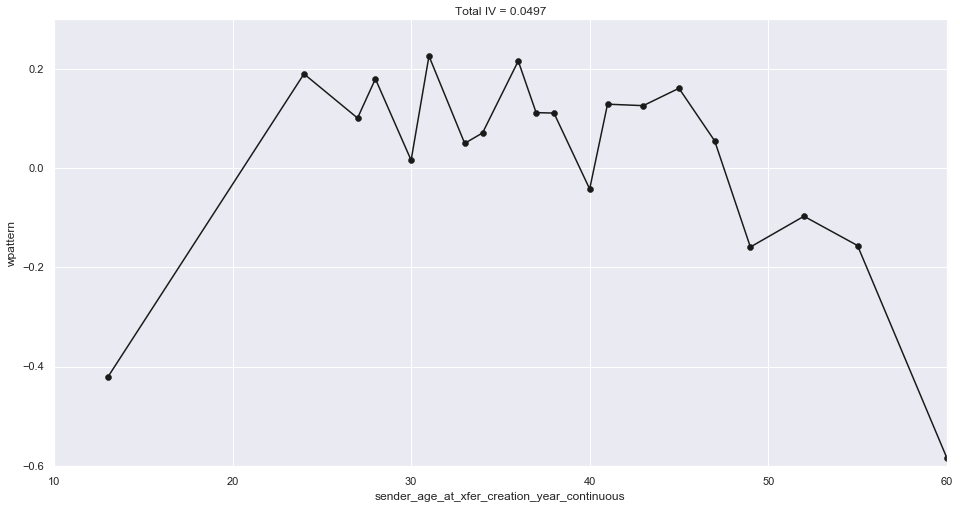

In [167]:
# WOE plot (weight-of-evidence)
def woe_plot(data_dir, varname, target, output, rs_rate_0=1, rs_rate_1=1, n_bins=20):
    """
    Args:
        data_dir
        varname
        target: Array of target, 0 or 1 for binary classification.
        output: Array of numerical signal.
        rs_rate_0: Reverse sampling rate for negative, default is 1.
        rs_rate_1: Reverse sampling rate for positive, default is 1.
        n_bins: Number of bins, default is 20.
    Returns:
        Returns weight of evidence for numeric with sampling rates.
    """
    import pandas as pd
    import numpy as np
    import bisect

    # Filter out NULLs.
    target = [target[i] for i, val in enumerate(output) if not pd.isnull(val)]
    output = [output[i] for i, val in enumerate(output) if not pd.isnull(val)]

    #interval = 1.0/n_bins
    sbreaks = np.linspace(0, 1, (n_bins + 1), endpoint=True)
    o_quar = pd.Series(output).quantile(sbreaks)
    a = sorted(o_quar.drop_duplicates())
    b = [bisect.bisect_right(a, x, lo=0, hi=(len(a)-1)) for x in output]

    n = len(a)
    tot = np.repeat(0, n-1)
    bads = np.repeat(0, n-1)
    goods = np.repeat(0, n-1)
    tmp = [target[i] for i, val in enumerate(target) if val==0]
    ngoods = len(tmp)*rs_rate_0
    tmp = [target[i] for i, val in enumerate(target) if val==1]
    nbads = len(tmp)*rs_rate_1
    ntot = ngoods + nbads

    for i in np.arange(1, n):
        st = [target[ix] for ix, val in enumerate(b) if val==i]
        tmp = [st[i] for i, val in enumerate(st) if val==0]
        goods[i-1] = len(tmp)*rs_rate_0
        tmp = [st[i] for i, val in enumerate(st) if val==1]
        bads[i-1] = len(tmp)*rs_rate_1
        tot[i-1] = goods[i-1] + bads[i-1]

    cumtot = np.cumsum(tot, dtype=float)
    cumbads = np.cumsum(bads, dtype=float)
    cumgoods = np.cumsum(goods, dtype=float)
    pctpop = cumtot/ntot

    prgoods = goods/ngoods
    prbads = bads/nbads
    wpattern = np.log(prgoods/prbads)
    prcumgoods = np.cumsum(prgoods)
    prcumbads = np.cumsum(prbads)
    iv = (prgoods - prbads)*wpattern

    iv = [iv[i] for i, val in enumerate(iv) if np.isfinite(val)]
    iv = [iv[i] for i, val in enumerate(iv) if not np.isnan(val)]
    sumiv = sum(iv)

    n = len(a) - 1
    z = pd.DataFrame({'Obs': np.linspace(1, n, n),
                      'var': a[:-1],
                      'goods': np.round(goods),
                      'bads': np.round(bads),
                      'prgoods': np.round(prgoods, 3),
                      'prbads': np.round(prbads, 3),
                      'wpattern': np.round(wpattern, 3),
                      'prcumgoods': np.round(prcumgoods, 3),
                      'prcumbads': np.round(prcumbads, 3),
                      'iv': np.round(iv, 3)
        })

    plt.figure(figsize=(16, 8))
    x = z['var']
    y = z['wpattern']
    plt.plot(x, y, '-ok');
    plt.title('Total IV = ' + str(round(sumiv, 4)))
    plt.xlabel(varname)
    plt.ylabel('wpattern')
    plt.savefig(data_dir + 'woe_' + varname + '.png')
    
    return z, sumiv


z_df, sumiv = woe_plot(data_dir, 'sender_age_at_xfer_creation_year_continuous', trn_final.flag, 
               trn_final.sender_age_at_xfer_creation_year_continuous, 1, 1, 20)
print(z_df, sumiv)


     Obs       var  goods  bads  prgoods  prbads  wpattern  prcumgoods  \
0    1.0  0.000000  22350  1153    0.047   0.313    -1.906       0.047   
1    2.0  1.386294  24282   572    0.051   0.155    -1.122       0.097   
2    3.0  3.688879  23934   226    0.050   0.061    -0.208       0.147   
3    4.0  4.356709  23572   168    0.049   0.046     0.074       0.196   
4    5.0  4.787492  24198   144    0.050   0.039     0.254       0.246   
5    6.0  5.105945  24032   138    0.050   0.037     0.290       0.296   
6    7.0  5.337538  23994   134    0.050   0.036     0.317       0.346   
7    8.0  5.533389  24250   116    0.050   0.031     0.472       0.397   
8    9.0  5.710427  24023   110    0.050   0.030     0.516       0.447   
9   10.0  5.894403  24236   104    0.050   0.028     0.581       0.497   
10  11.0  6.052089  24060   122    0.050   0.033     0.414       0.548   
11  12.0  6.186209  24227   112    0.050   0.030     0.506       0.598   
12  13.0  6.322565  23991   104    0.0

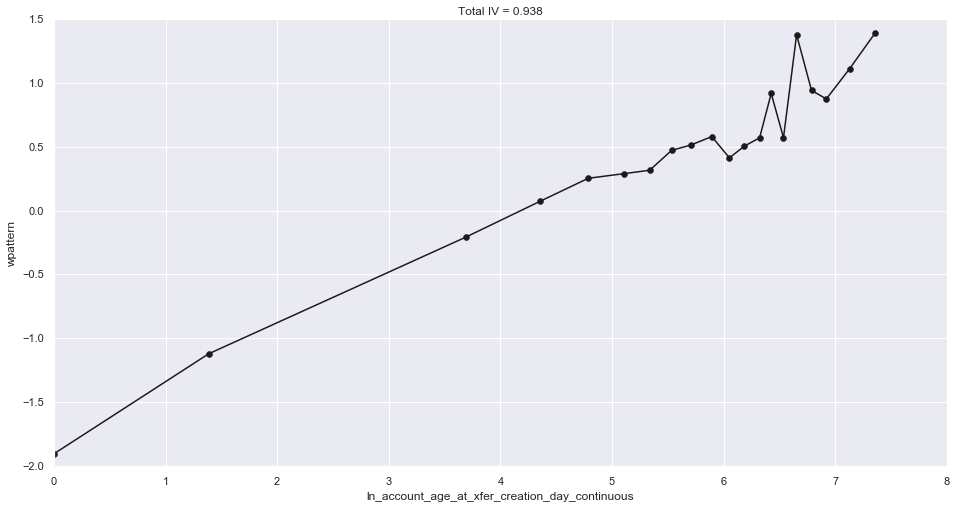

In [147]:
z, sumiv = woe_plot(data_dir, 'ln_account_age_at_xfer_creation_day_continuous', trn_final.flag, 
               trn_final.ln_account_age_at_xfer_creation_day_continuous, 1, 1, 20)
print(z, sumiv)


     Obs   var   goods  bads  prgoods  prbads  wpattern  prcumgoods  \
0    1.0  13.0  208702  1478    0.435   0.401     0.080       0.430   
9    2.0  37.0   17061   117    0.036   0.032     0.112       0.470   
10   3.0  38.0   34361   236    0.072   0.064     0.111       0.542   
11   4.0  40.0   16367   131    0.034   0.036    -0.042       0.576   
12   5.0  41.0   29201   197    0.061   0.053     0.129       0.637   
13   6.0  43.0   25863   175    0.054   0.048     0.126       0.690   
14   7.0  45.0   23884   156    0.050   0.042     0.161       0.740   
15   8.0  47.0   21615   157    0.045   0.043     0.055       0.785   
16   9.0  49.0   28139   253    0.059   0.069    -0.159       0.844   
17  10.0  52.0   22592   191    0.047   0.052    -0.097       0.891   
18  11.0  55.0   26773   240    0.056   0.065    -0.156       0.947   
19  12.0  60.0   25653   353    0.053   0.096    -0.584       1.000   

    prcumbads     iv  
0       0.400  0.000  
9       0.433  0.000  
10     

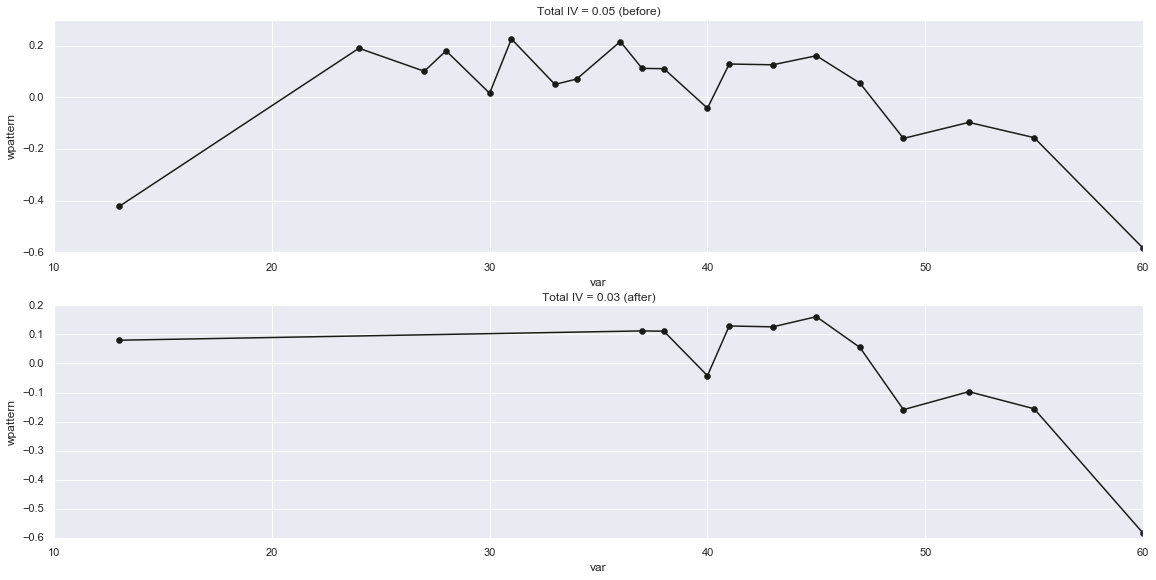

In [168]:
# IV merge
def iv_merge(x, sbin, ebin, data_dir, varname):
    """
    Args:
        x: An IV dataframe with 10 columns
        (1) Obs
        (2) var
        (3) goods
        (4) bads
        (5) prgoods
        (6) prbads
        (7) wpattern
        (8) prcumgoods
        (9) prcumbads
        (10) iv
        sbin: starting bin.
        ebin: ending bin.
        data_dir
        varname
    Returns:
        merged iv dataframe.
    """
    import numpy as np
    import pandas as pd

    row = x.shape[0]
    col = x.shape[1]
    totgoods = np.sum(x['goods'])
    totbads = np.sum(x['bads'])

    if sbin==1:
        preprcumgoods = 0
        preprcumbads = 0
    else:
        a_list = x.prcumgoods
        preprcumgoods = [a_list[i] for i, val in enumerate(x.Obs) if val==(sbin-1)][0]
        a_list = x.prcumbads
        ppreprcumbadsreprcumgoods = [a_list[i] for i, val in enumerate(x.Obs) if val==(sbin-1)][0]

    var = x[x.Obs==sbin]['var'][0]
    goods = np.sum(x[((x.Obs >= sbin) & (x.Obs <= ebin))]['goods'])
    bads = np.sum(x[((x.Obs >= sbin) & (x.Obs <= ebin))]['bads'])
    prgoods = goods/totgoods
    prbads = bads/totbads
    wpattern = np.log(prgoods/prbads)
    prcumgoods = preprcumgoods + prgoods
    prcumbads = preprcumbads + prbads
    iv = (prgoods - prbads)*wpattern
    
    body = pd.DataFrame({'Obs': [1],
                      'var': [var],
                      'goods': [goods],
                      'bads': [bads],
                      'prgoods': [round(prgoods, 3)],
                      'prbads': [round(prbads, 3)],
                      'wpattern': [round(wpattern, 2)],
                      'prcumgoods': [round(prcumgoods, 2)],
                      'prcumbads': [round(prcumbads, 2)],
                      'iv': [round(iv, 2)]
    })
    
    if sbin==1:
        df = x[((x.Obs >= (ebin+1)) & (x.Obs <= row))]
        z = pd.concat([body, df], axis=0)
    elif ebin==row:
        df = x[((x.Obs >= 1) & (x.Obs <= (sbin-1)))]
        z = pd.concat([df, body], axis=0)
    else:
        df1 = x[((x.Obs >= 1) & (x.Obs <= (sbin-1)))]
        df2 = x[((x.Obs >= (ebin+1)) & (x.Obs <= row))]
        z = pd.concat([df1, body, df2], axis=0)

    row_cnt = z.shape[0]
    z['Obs'] = list(np.linspace(1, row_cnt, row_cnt))

    # Bofore merge.
    iv = list(x['iv'])
    iv = [iv[i] for i, val in enumerate(iv) if np.isfinite(val)]
    iv = [iv[i] for i, val in enumerate(iv) if not np.isnan(val)]
    sumiv = sum(iv)

    plt.figure(figsize=(16, 8))
    x1 = x['var']
    y1 = x['wpattern']
    plt.subplot(2, 1, 1)
    plt.plot(x1, y1, '-ok');
    plt.title('Total IV = ' + str(round(sumiv, 2)) + ' (before)')
    plt.xlabel('var')
    plt.ylabel('wpattern')

    # After merge.
    iv = list(z['iv'])    
    iv = [iv[i] for i, val in enumerate(iv) if np.isfinite(val)]
    iv = [iv[i] for i, val in enumerate(iv) if not np.isnan(val)]
    sumiv = sum(iv)

    plt.subplot(2, 1, 2)
    x1 = z['var']
    y1 = z['wpattern']
    plt.plot(x1, y1, '-ok');
    plt.title('Total IV = ' + str(round(sumiv, 2)) + ' (after)')
    plt.xlabel('var')
    plt.ylabel('wpattern')

    plt.tight_layout(pad=0.5)
    plt.savefig(data_dir + 'iv_merge_' + varname + '.png')
    return z

merged_z_df = iv_merge(z_df, 1, 9, data_dir, 'sender_age_at_xfer_creation_year_continuous')
print(merged_z_df)
